# Exploratory Data Analysis - Credit Default Prediction

This notebook performs focused EDA on the gold layer data to inform model selection and training.

**Sections:**
1. Setup & Data Loading
2. Summary of Features
3. Feature Correlation Analysis
4. Meaningful Feature Exploration
5. Visualizations for Presentation

## 1. Setup & Data Loading

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pyspark
from pyspark.sql.functions import col

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Create figures directory for saving visualizations
os.makedirs('figures', exist_ok=True)

In [2]:
# Initialize Spark Session (or get existing one)
from pyspark.sql import SparkSession

spark = pyspark.sql.SparkSession.builder \
    .appName("eda-analysis") \
    .master("local[*]") \
    .config("spark.sql.parquet.enableVectorizedReader", "false") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

print(f"Spark Session initialized: {spark.sparkContext.appName}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/25 11:12:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session initialized: eda-analysis


Check Schema

In [70]:
MAIN_DATA_DIR = "/app/datamart/gold/feature_store" 
# Assuming 'spark' session is available

all_files = [os.path.join(MAIN_DATA_DIR, f) for f in os.listdir(MAIN_DATA_DIR) if f.endswith('.parquet')]

print(f"Starting file-by-file schema check on {len(all_files)} files...")

for file_path in all_files:
    file_name = os.path.basename(file_path)
    
    try:
        # Attempt to read ONLY the file's schema
        spark.read.parquet(file_path).printSchema()
        print(f"SUCCESS: {file_name}")

    except Exception as e:
        print(f"--- FAILURE DETECTED: {file_name} ---")
        print(f"ERROR: {e}")
        # THIS IS YOUR CULPRIT! Stop and examine this file's contents and the script that generated it.
        break # Stop the loop once the first bad file is found

Starting file-by-file schema check on 25 files...
root
 |-- Customer_ID: string (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- Age: string (nullable = true)
 |-- occupation_category: string (nullable = true)
 |-- Annual_Income: float (nullable = true)
 |-- Num_Bank_Accounts: integer (nullable = true)
 |-- Num_Credit_Card: integer (nullable = true)
 |-- Interest_Rate: float (nullable = true)
 |-- Num_of_Loan: integer (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Delay_from_due_date: integer (nullable = true)
 |-- Num_of_Delayed_Payment: integer (nullable = true)
 |-- Changed_Credit_Limit: float (nullable = true)
 |-- Num_Credit_Inquiries: integer (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: float (nullable = true)
 |-- Credit_Utilization_Ratio: float (nullable = true)
 |-- Payment_of_Min_Amount: string (nullable = true)
 |-- Total_EMI_per_month: float (nullable = true)
 |-- Amount_invested_monthly: float (null

#1 Bug

Fix Age - Stored as string instead of integer
File: utils/silver_layer.py Problem:
Line 30: Age in numeric_fields_to_clean (637 rows have underscores - needs it)
Line 33: regexp_replace converts Age to string
Line 36-42: Age NOT in column_type_map → stays string
Verified: 5% of data has underscores like "40_", needs cleaning
Fix: Add Age: IntegerType() to column_type_map at line 36-42 to cast cleaned string back to integer

## 2. Summary of Features

In [3]:
# Load Feature Store (Gold Layer) - Read files individually due to schema inconsistencies
import glob

feature_path = 'datamart/gold/feature_store/'
parquet_dirs = glob.glob(f'{feature_path}*/')

# Read each parquet directory separately and collect as pandas DataFrames
df_list = []
for parquet_dir in sorted(parquet_dirs):
    try:
        df_temp = spark.read.parquet(parquet_dir).toPandas()
        df_list.append(df_temp)
        print(f"Loaded {parquet_dir}: {len(df_temp)} rows")
    except Exception as e:
        print(f"Error loading {parquet_dir}: {e}")

# Concatenate all DataFrames
df_features = pd.concat(df_list, ignore_index=True)

print(f"\nFeature Store Shape: {df_features.shape}")
print(f"Date Range: {df_features['snapshot_date'].min()} to {df_features['snapshot_date'].max()}")

Loaded datamart/gold/feature_store/gold_feature_store_2023_01_01.parquet/: 530 rows
Loaded datamart/gold/feature_store/gold_feature_store_2023_02_01.parquet/: 501 rows
Loaded datamart/gold/feature_store/gold_feature_store_2023_03_01.parquet/: 506 rows
Loaded datamart/gold/feature_store/gold_feature_store_2023_04_01.parquet/: 510 rows
Loaded datamart/gold/feature_store/gold_feature_store_2023_05_01.parquet/: 521 rows
Loaded datamart/gold/feature_store/gold_feature_store_2023_06_01.parquet/: 517 rows
Loaded datamart/gold/feature_store/gold_feature_store_2023_07_01.parquet/: 471 rows
Loaded datamart/gold/feature_store/gold_feature_store_2023_08_01.parquet/: 481 rows
Loaded datamart/gold/feature_store/gold_feature_store_2023_09_01.parquet/: 454 rows
Loaded datamart/gold/feature_store/gold_feature_store_2023_10_01.parquet/: 487 rows
Loaded datamart/gold/feature_store/gold_feature_store_2023_11_01.parquet/: 491 rows
Loaded datamart/gold/feature_store/gold_feature_store_2023_12_01.parquet/: 4

In [31]:
display(df_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer_ID                  12500 non-null  object 
 1   snapshot_date                12500 non-null  object 
 2   Age                          11899 non-null  object 
 3   occupation_category          12500 non-null  object 
 4   Annual_Income                12500 non-null  float32
 5   Num_Bank_Accounts            12326 non-null  float64
 6   Num_Credit_Card              12204 non-null  float64
 7   Interest_Rate                12230 non-null  float32
 8   Num_of_Loan                  12000 non-null  float64
 9   Type_of_Loan                 10898 non-null  object 
 10  Delay_from_due_date          12500 non-null  int32  
 11  Num_of_Delayed_Payment       12416 non-null  float64
 12  Changed_Credit_Limit         12246 non-null  float32
 13  Num_Credit_Inqui

None

In [60]:
df_features.head(5)

,Customer_ID,snapshot_date,Age,occupation_category,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,...,Payment_Behaviour,Monthly_Balance,Credit_history_total_months,Debt_to_income_ratio,visit_frequency,last_activity_date,recent_total_activity,avg_activity_intensity,total_active_features,financial_health_score
0,CUS_0x1037,2023-01-01,45,technical,15989.084961,5.0,4.0,2.0,4.0,"Credit-Builder Loan, Auto Loan, Auto Loan, and...",...,Low_spent_Small_value_payments,284.380127,237,0.041642,NaN,None,NaN,NaN,NaN,4
1,CUS_0x1069,2023-01-01,32,technical,58637.339844,4.0,6.0,10.0,119.0,"Personal Loan, Auto Loan, and Not Specified",...,High_spent_Small_value_payments,434.848877,368,0.003561,NaN,None,NaN,NaN,NaN,5
2,CUS_0x114a,2023-01-01,43,other,15305.459961,0.0,7.0,2.0,2.0,"Student Loan, and Home Equity Loan",...,Low_spent_Small_value_payments,327.965363,189,0.041973,NaN,None,NaN,NaN,NaN,5
3,CUS_0x1184,2023-01-01,49,professional,19867.474609,3.0,5.0,11.0,3.0,"Student Loan, Mortgage Loan, and Payday Loan",...,None,313.594452,392,0.035600,NaN,None,NaN,NaN,NaN,5
4,CUS_0x1297,2023-01-01,46,business,57738.058594,9.0,8.0,30.0,9.0,"Payday Loan, Personal Loan, Payday Loan, Perso...",...,High_spent_Medium_value_payments,388.045197,164,0.067832,NaN,None,NaN,NaN,NaN,5


In [32]:
print("=" * 50)
print("1. DATA SHAPE AND SAMPLE")
print("=" * 50)
print(f"Dataset Shape: {df_features.shape}")

print("\nBasic Numerical Statistics:")
# Transpose (.T) for easier reading
display(df_features.describe().T)

1. DATA SHAPE AND SAMPLE
Dataset Shape: (12500, 30)

Basic Numerical Statistics:


/usr/local/lib/python3.12/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max
Annual_Income,12500.0,1.616205e+05,1.297842e+06,7.005930e+03,19453.327637,37572.375000,72690.214844,2.383470e+07
Num_Bank_Accounts,12326.0,5.364676e+00,2.593670e+00,0.000000e+00,3.000000,5.000000,7.000000,1.000000e+01
Num_Credit_Card,12204.0,5.535234e+00,2.070895e+00,0.000000e+00,4.000000,5.000000,7.000000,1.100000e+01
Interest_Rate,12230.0,1.455626e+01,8.753709e+00,1.000000e+00,7.000000,13.000000,20.000000,3.400000e+01
Num_of_Loan,12000.0,7.395250e+00,6.288033e+01,0.000000e+00,2.000000,3.000000,5.000000,1.495000e+03
Delay_from_due_date,12500.0,2.106088e+01,1.486309e+01,-5.000000e+00,10.000000,18.000000,28.000000,6.700000e+01
Num_of_Delayed_Payment,12416.0,3.325918e+01,2.394850e+02,0.000000e+00,9.000000,14.000000,18.000000,4.293000e+03
Changed_Credit_Limit,12246.0,1.039858e+01,6.799253e+00,-6.490000e+00,5.370000,9.410000,14.940000,3.697000e+01
Num_Credit_Inquiries,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Outstanding_Debt,12500.0,1.426220e+03,1.155169e+03,2.300000e-01,566.072510,1166.154968,1945.962555,4.998070e+03


2. MISSING VALUE SUMMARY


,Column,Missing Count,Missing Percent
13,Num_Credit_Inquiries,12500,100.000
24,visit_frequency,4056,32.448
27,avg_activity_intensity,4056,32.448
26,recent_total_activity,4056,32.448
25,last_activity_date,4056,32.448
28,total_active_features,4056,32.448
14,Credit_Mix,2611,20.888
9,Type_of_Loan,1602,12.816
20,Payment_Behaviour,998,7.984
2,Age,601,4.808


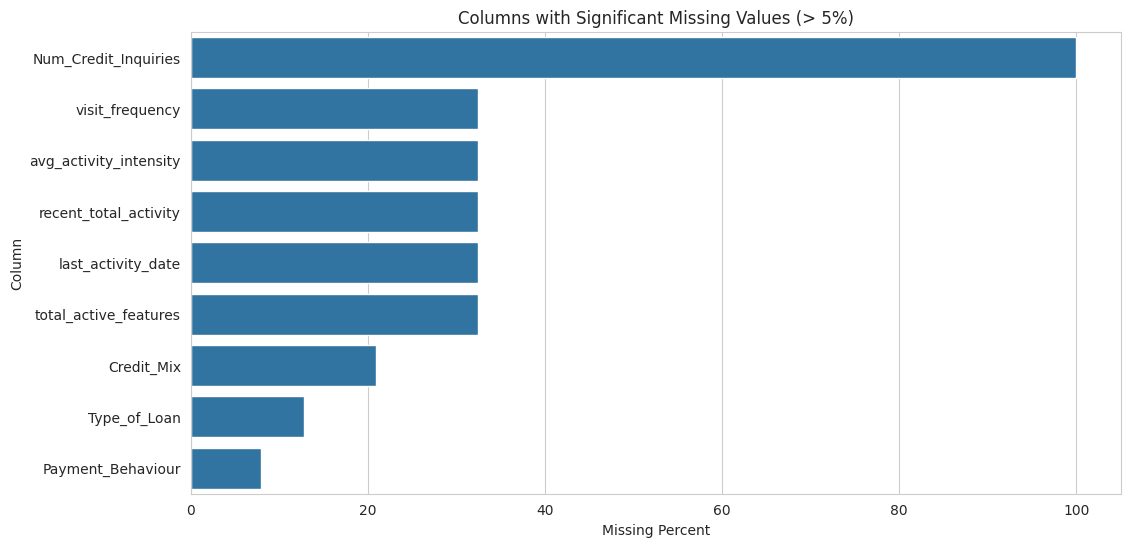

In [86]:
print("=" * 50)
print("2. MISSING VALUE SUMMARY")
print("=" * 50)

# Calculate missing value percentages
missing_info = df_features.isnull().sum().reset_index()
missing_info.columns = ['Column', 'Missing Count']
missing_info['Missing Percent'] = (missing_info['Missing Count'] / len(df_features)) * 100

# Filter to show only columns with missing data, sorted by count
missing_df = missing_info[missing_info['Missing Count'] > 0].sort_values(
    by='Missing Count', ascending=False
)
display(missing_df)

# Plot columns with over 5% missing data
plt.figure(figsize=(12, 6))
sns.barplot(x='Missing Percent', y='Column', data=missing_df[missing_df['Missing Percent'] > 5])
plt.title('Columns with Significant Missing Values (> 5%)')
plt.show()

In [ ]:
# 1. Check if all missing clickstream data is due to first month data not available
filtered_df = df_features[df_features['snapshot_date'] == '2023-01-01']

# 2. Check the shape of the filtered result
filtered_df.shape

(530, 30)

#Bug 2

Fix Num_Credit_Inquiries - 100% NULL values
File: utils/silver_layer.py Problem:
Line 152: Num_Credit_Inquiries in numeric_fields_to_clean
regexp_replace converts it to string "2.0"
Line 194: try_cast("2.0" as int) fails → NULL
Verified: 0 underscores in source data (doesn't need cleaning)
Fix: Remove Num_Credit_Inquiries from numeric_fields_to_clean list at line 148-155

#Bug 3

Fix Clickstream Missing Values - Semantic clarity
File: utils/gold_layer.py Problem:
January 2023: No previous month clickstream → all customers get NULL (correct)
Other months: Customers who didn't click → get NULL (should be 0)
NULL means both "no data available" and "no activity" (ambiguous)
Fix: Add conditional fill logic after line 66:
If previous month data exists → Fill NULL with 0 (customer didn't click)
If previous month doesn't exist → Keep NULL (no data available)
Implementation:
Add prev_month_data_exists flag in try/except block
After join, conditionally fill clickstream columns based on flag
Apply to: visit_frequency, recent_total_activity, avg_activity_intensity, total_active_features

In [83]:
print("=" * 80)
print("3. NUMERICAL DATA VERIFICATION")
print("=" * 80)

# Identify column types
numeric_cols = [
    'Age','Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate',
    'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 
    'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt',
    'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly',
    'Monthly_Balance', 'Credit_history_total_months', 'Debt_to_income_ratio',
    'visit_frequency', 'recent_total_activity', 'avg_activity_intensity',
    'total_active_features', 'financial_health_score'
]

print(f"\nNumeric columns: {len(numeric_cols)}")
# NUMERIC COLUMNS - Quality Check
print("\n" + "=" * 80)
print("NUMERIC COLUMNS - QUALITY CHECK")
print("=" * 80)

numeric_quality = []

for col_name in numeric_cols:
    total_count = len(df)
    null_count = df[col_name].isnull().sum()
    null_pct = (null_count / total_count * 100)
    
    # Get non-null values
    non_null_values = df[col_name].dropna()
    
    if len(non_null_values) > 0:
        # Check for non-numeric values
        numeric_values = pd.to_numeric(non_null_values, errors='coerce')
        non_numeric_count = numeric_values.isnull().sum()
        
        # Calculate extreme outliers (using 3*IQR)
        Q1 = non_null_values.quantile(0.25)
        Q3 = non_null_values.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        extreme_outliers = ((non_null_values < lower_bound) | (non_null_values > upper_bound)).sum()
        
        numeric_quality.append({
            'Column': col_name,
            'Null_Count': null_count,
            'Null_%': f"{null_pct:.1f}",
            'Non_Numeric': non_numeric_count,
            'Extreme_Outliers': extreme_outliers,
            'Min': f"{non_null_values.min():.2f}",
            'Max': f"{non_null_values.max():.2f}"
        })
    else:
        numeric_quality.append({
            'Column': col_name,
            'Null_Count': null_count,
            'Null_%': f"{null_pct:.1f}",
            'Non_Numeric': 0,
            'Extreme_Outliers': 0,
            'Min': 'N/A',
            'Max': 'N/A'
        })

df_numeric_quality = pd.DataFrame(numeric_quality)
print(df_numeric_quality.to_string(index=False))

3. NUMERICAL DATA VERIFICATION

Numeric columns: 22

NUMERIC COLUMNS - QUALITY CHECK
                     Column  Null_Count Null_%  Non_Numeric  Extreme_Outliers                             Min         Max
                        Age         453    4.8            0                 0                           16.00       56.00
              Annual_Income           0    0.0            0                85                         7005.93 23834698.00
          Num_Bank_Accounts         126    1.3            0                 0                            0.00       10.00
            Num_Credit_Card         231    2.4            0                 0                            0.00       11.00
              Interest_Rate         208    2.2            0                 0                            1.00       34.00
                Num_of_Loan         370    3.9            0                47                            0.00     1495.00
        Delay_from_due_date           0    0.0            0  

#4 Bug Define boundaries to cut off extreme outliers

Define Boundaries for numerical values in silver table.

#handle extreme outlier found out in eda
outlier_bounds = {
    "Num_Bank_Accounts": (0, 10),
    "Num_Credit_Card": (0, 15),
    "Interest_Rate": (0, 50),
    "Num_Credit_Inquiries": (0, 50),
    "Total_EMI_per_month": (0, 10000),
    "Num_of_Loan": (0, 20),
    "Num_of_Delayed_Payment": (0, 100),
    "Annual_Income": (0, 1000000),
    "Amount_invested_monthly": (0, 10000),
    "Monthly_Balance": (-10000, 100000),
    "Outstanding_Debt": (0, 50000),
    "Delay_from_due_date": (0, 365),
}

In [88]:
# CATEGORICAL COLUMNS - Quality Check
print("\n" + "=" * 80)
print("CATEGORICAL COLUMNS - QUALITY CHECK")
print("=" * 80)

categorical_cols = [
    'occupation_category', 'Type_of_Loan', 'Credit_Mix', 
    'Payment_of_Min_Amount', 'Payment_Behaviour'
]

print(f"Categorical columns: {len(categorical_cols)}")

categorical_quality = []

for col_name in categorical_cols:
    total_count = len(df_features)
    null_count = df_features[col_name].isnull().sum()
    null_pct = (null_count / total_count * 100)
    
    non_null_values = df_features[col_name].dropna()
    n_unique = non_null_values.nunique()
    
    categorical_quality.append({
        'Column': col_name,
        'Null_Count': null_count,
        'Null_%': f"{null_pct:.1f}",
        'N_Unique': n_unique
    })

df_categorical_quality = pd.DataFrame(categorical_quality)
print(df_categorical_quality.to_string(index=False))



CATEGORICAL COLUMNS - QUALITY CHECK
Categorical columns: 5
               Column  Null_Count Null_%  N_Unique
  occupation_category           0    0.0         5
         Type_of_Loan        1602   12.8      6259
           Credit_Mix        2611   20.9         3
Payment_of_Min_Amount           0    0.0         3
    Payment_Behaviour         998    8.0         6


Label Store EDA

In [ ]:
print("=" * 80)
print("3. NUMERICAL DATA VERIFICATION")
print("=" * 80)

# Identify column types
numeric_cols = [
    'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate',
    'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 
    'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt',
    'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly',
    'Monthly_Balance', 'Credit_history_total_months', 'Debt_to_income_ratio',
    'visit_frequency', 'recent_total_activity', 'avg_activity_intensity',
    'total_active_features', 'financial_health_score'
]

print(f"\nNumeric columns: {len(numeric_cols)}")
# NUMERIC COLUMNS - Quality Check
print("\n" + "=" * 80)
print("NUMERIC COLUMNS - QUALITY CHECK")
print("=" * 80)

numeric_quality = []

for col_name in numeric_cols:
    total_count = len(df)
    null_count = df[col_name].isnull().sum()
    null_pct = (null_count / total_count * 100)
    
    # Get non-null values
    non_null_values = df[col_name].dropna()
    
    if len(non_null_values) > 0:
        # Check for non-numeric values
        numeric_values = pd.to_numeric(non_null_values, errors='coerce')
        non_numeric_count = numeric_values.isnull().sum()
        
        # Calculate extreme outliers (using 3*IQR)
        Q1 = non_null_values.quantile(0.25)
        Q3 = non_null_values.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        extreme_outliers = ((non_null_values < lower_bound) | (non_null_values > upper_bound)).sum()
        
        numeric_quality.append({
            'Column': col_name,
            'Null_Count': null_count,
            'Null_%': f"{null_pct:.1f}",
            'Non_Numeric': non_numeric_count,
            'Extreme_Outliers': extreme_outliers,
            'Min': f"{non_null_values.min():.2f}",
            'Max': f"{non_null_values.max():.2f}"
        })
    else:
        numeric_quality.append({
            'Column': col_name,
            'Null_Count': null_count,
            'Null_%': f"{null_pct:.1f}",
            'Non_Numeric': 0,
            'Extreme_Outliers': 0,
            'Min': 'N/A',
            'Max': 'N/A'
        })

df_numeric_quality = pd.DataFrame(numeric_quality)
print(df_numeric_quality.to_string(index=False))

3. NUMERICAL DATA VERIFICATION

Numeric columns: 21

NUMERIC COLUMNS - QUALITY CHECK
                     Column  Null_Count Null_%  Non_Numeric  Extreme_Outliers                             Min         Max
              Annual_Income           0    0.0            0                85                         7005.93 23834698.00
          Num_Bank_Accounts         126    1.3            0                 0                            0.00       10.00
            Num_Credit_Card         231    2.4            0                 0                            0.00       11.00
              Interest_Rate         208    2.2            0                 0                            1.00       34.00
                Num_of_Loan         370    3.9            0                47                            0.00     1495.00
        Delay_from_due_date           0    0.0            0                 0                           -5.00       67.00
     Num_of_Delayed_Payment          61    0.6            0  

In [29]:
# Load Label Store (Gold Layer) - Read files individually
label_path = 'datamart/gold/label_store/'
label_parquet_dirs = glob.glob(f'{label_path}*/')

# Read each parquet directory separately
label_list = []
for parquet_dir in sorted(label_parquet_dirs):
    try:
        df_temp = spark.read.parquet(parquet_dir).toPandas()
        label_list.append(df_temp)
        print(f"Loaded {parquet_dir}: {len(df_temp)} rows")
    except Exception as e:
        print(f"Error loading {parquet_dir}: {e}")

# Concatenate all DataFrames
df_labels = pd.concat(label_list, ignore_index=True)

print(f"\nLabel Store Shape: {df_labels.shape}")
print(f"Date Range: {df_labels['snapshot_date'].min()} to {df_labels['snapshot_date'].max()}")

Loaded datamart/gold/label_store/gold_label_store_2023_01_01.parquet/: 0 rows
Loaded datamart/gold/label_store/gold_label_store_2023_02_01.parquet/: 0 rows
Loaded datamart/gold/label_store/gold_label_store_2023_03_01.parquet/: 0 rows
Loaded datamart/gold/label_store/gold_label_store_2023_04_01.parquet/: 0 rows
Loaded datamart/gold/label_store/gold_label_store_2023_05_01.parquet/: 0 rows


Loaded datamart/gold/label_store/gold_label_store_2023_06_01.parquet/: 0 rows
Loaded datamart/gold/label_store/gold_label_store_2023_07_01.parquet/: 530 rows
Loaded datamart/gold/label_store/gold_label_store_2023_08_01.parquet/: 501 rows
Loaded datamart/gold/label_store/gold_label_store_2023_09_01.parquet/: 506 rows
Loaded datamart/gold/label_store/gold_label_store_2023_10_01.parquet/: 510 rows
Loaded datamart/gold/label_store/gold_label_store_2023_11_01.parquet/: 521 rows
Loaded datamart/gold/label_store/gold_label_store_2023_12_01.parquet/: 517 rows
Loaded datamart/gold/label_store/gold_label_store_2024_01_01.parquet/: 471 rows
Loaded datamart/gold/label_store/gold_label_store_2024_02_01.parquet/: 481 rows
Loaded datamart/gold/label_store/gold_label_store_2024_03_01.parquet/: 454 rows
Loaded datamart/gold/label_store/gold_label_store_2024_04_01.parquet/: 487 rows
Loaded datamart/gold/label_store/gold_label_store_2024_05_01.parquet/: 491 rows
Loaded datamart/gold/label_store/gold_labe

In [30]:
df_labels.head()

,loan_id,Customer_ID,label,label_def,snapshot_date
0,CUS_0x1037_2023_01_01,CUS_0x1037,0,30dpd_6mob,2023-07-01
1,CUS_0x1069_2023_01_01,CUS_0x1069,0,30dpd_6mob,2023-07-01
2,CUS_0x114a_2023_01_01,CUS_0x114a,0,30dpd_6mob,2023-07-01
3,CUS_0x1184_2023_01_01,CUS_0x1184,0,30dpd_6mob,2023-07-01
4,CUS_0x1297_2023_01_01,CUS_0x1297,1,30dpd_6mob,2023-07-01


In [35]:
df_labels.head()

,loan_id,Customer_ID,label,label_def,snapshot_date
0,CUS_0x1037_2023_01_01,CUS_0x1037,0,30dpd_6mob,2023-07-01
1,CUS_0x1069_2023_01_01,CUS_0x1069,0,30dpd_6mob,2023-07-01
2,CUS_0x114a_2023_01_01,CUS_0x114a,0,30dpd_6mob,2023-07-01
3,CUS_0x1184_2023_01_01,CUS_0x1184,0,30dpd_6mob,2023-07-01
4,CUS_0x1297_2023_01_01,CUS_0x1297,1,30dpd_6mob,2023-07-01


In [36]:
df_labels['snapshot_date'] = pd.to_datetime(df_labels['snapshot_date'])

In [66]:
import pandas as pd

# Assuming df_labels is the DataFrame containing the label store data

print("=" * 50)
print("1. DATA VALIDITY CHECKS")
print("=" * 50)

# Check 1: Unique Identifiers (Should be True)
# The 'loan_id' should be unique since it's a composite key of Customer_ID and date
print(f"Is 'loan_id' Unique? {df_labels['loan_id'].is_unique}")

# Check 2: Customer ID Uniqueness (Should be False for time series)
print(f"Total Unique Customers: {df_labels['Customer_ID'].nunique()}")
print(f"Total Rows: {len(df_labels)}")

# Check 3: Label Range (Should be only 0 and 1)
label_values = df_labels['label'].unique()
print(f"Unique 'label' values: {label_values}")
if all(val in [0, 1] for val in label_values):
    print("✅ Label values are binary (0/1).")
else:
    print("⚠️ WARNING: 'label' contains values outside of [0, 1].")

# Check 4: Date Consistency
# Check if all snapshot dates are consistent (e.g., end-of-month)
print(f"Unique Snapshot Days: {df_labels['snapshot_date'].dt.day.unique()}")

# Check 5: Date min and max
print(f"Earliest Default date: {df_labels['snapshot_date'].min()}")
print(f"Latest Default Date: {df_labels['snapshot_date'].max()}")
print(f"Number of unique snapshot dates: {df_labels['snapshot_date'].nunique()}")

1. DATA VALIDITY CHECKS
Is 'loan_id' Unique? True
Total Unique Customers: 9479
Total Rows: 9479
Unique 'label' values: [0 1]
✅ Label values are binary (0/1).
Unique Snapshot Days: [1]
Earliest Default date: 2023-07-01 00:00:00
Latest Default Date: 2025-01-01 00:00:00
Number of unique snapshot dates: 19


In [38]:
print("=" * 50)
print("2. MISSING VALUE SUMMARY")
print("=" * 50)

# The label store should have zero missing values in key columns
missing_counts = df_labels[['loan_id', 'Customer_ID', 'label', 'snapshot_date']].isnull().sum()

print("Missing Counts for Key Columns:")
print(missing_counts)

# General Missing Count Report
total_missing = df_labels.isnull().sum().sum()
if total_missing == 0:
    print("✅ No missing values found in the label store.")
else:
    print(f"⚠️ Total missing values found across ALL columns: {total_missing}")

2. MISSING VALUE SUMMARY
Missing Counts for Key Columns:
loan_id          0
Customer_ID      0
label            0
snapshot_date    0
dtype: int64
✅ No missing values found in the label store.


3. LABEL DISTRIBUTION (CLASS BALANCE)
Label Distribution:
   Label  Percentage
0      0       71.03
1      1       28.97


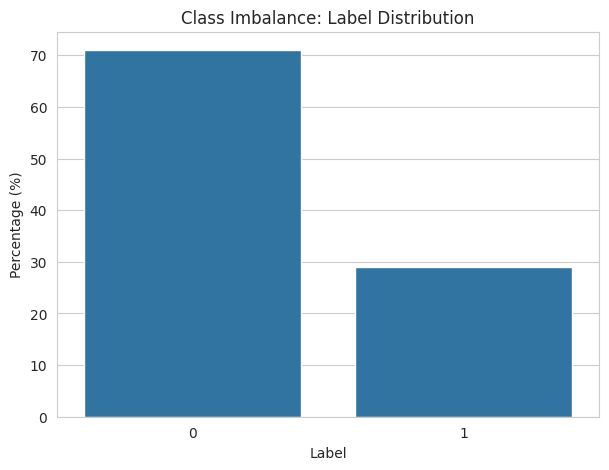

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 50)
print("3. LABEL DISTRIBUTION (CLASS BALANCE)")
print("=" * 50)

# Calculate and print the class distribution
label_distribution = df_labels['label'].value_counts(normalize=True).mul(100).round(2)
label_distribution_df = label_distribution.reset_index()
label_distribution_df.columns = ['Label', 'Percentage']

print(f"Label Distribution:\n{label_distribution_df}")

# Plot the class distribution
plt.figure(figsize=(7, 5))
sns.barplot(x='Label', y='Percentage', data=label_distribution_df, )
plt.title('Class Imbalance: Label Distribution')
plt.ylabel('Percentage (%)')
plt.show()

## 3. Feature Correlation Analysis

FEATURE CORRELATION HEATMAP (Multicollinearity Check)


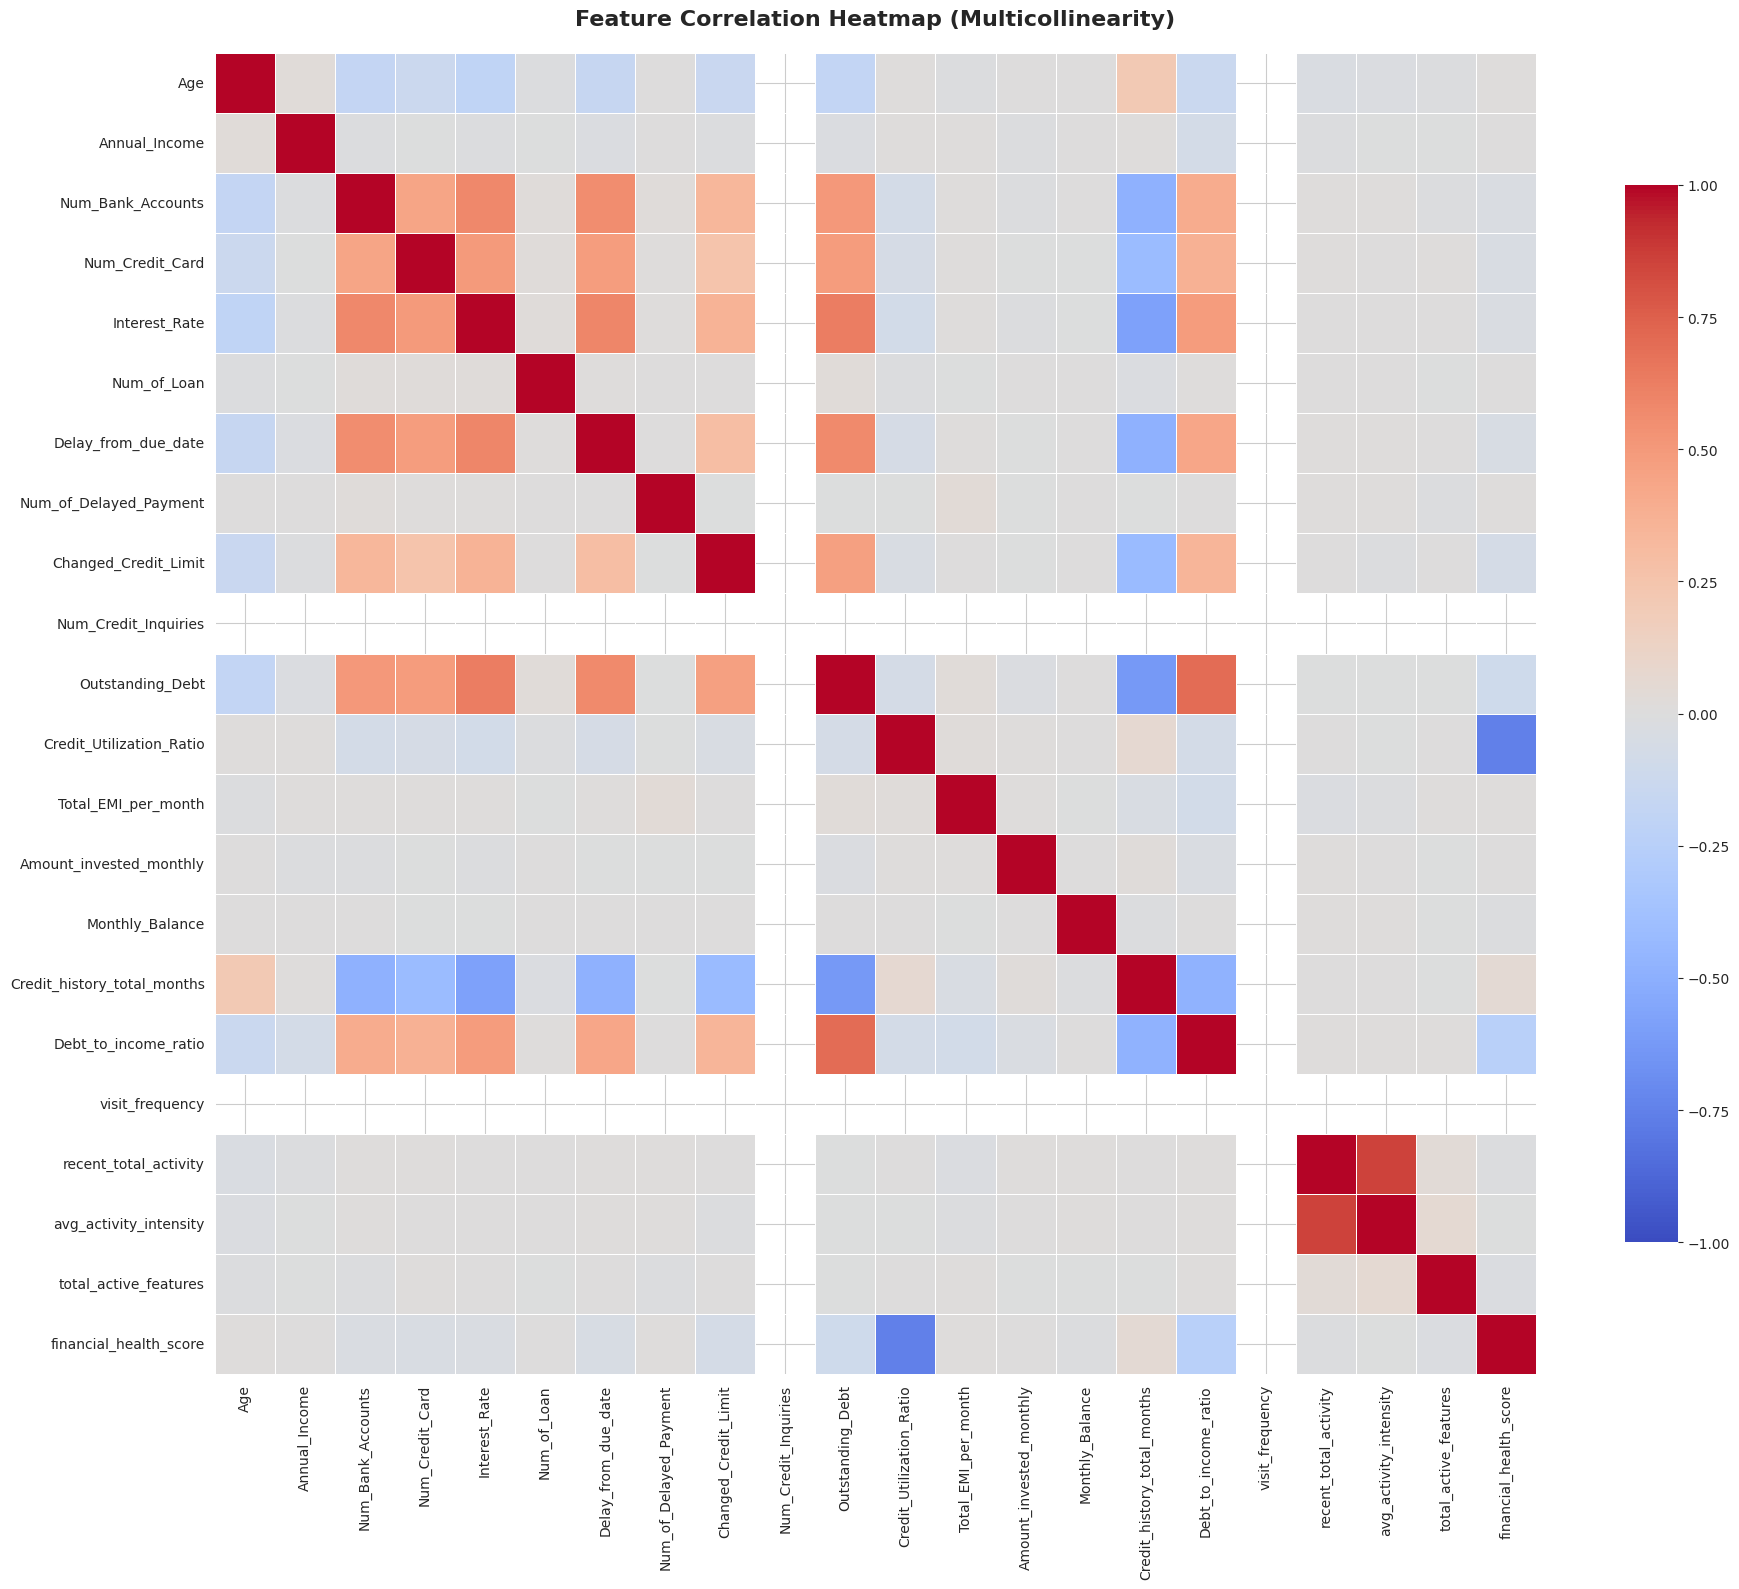


Highly Correlated Feature Pairs (|r| > 0.8):
            Feature 1              Feature 2  Correlation
recent_total_activity avg_activity_intensity     0.859311


In [95]:
# Feature Correlation Heatmap (Features Only - No Label)
print('=' * 80)
print('FEATURE CORRELATION HEATMAP (Multicollinearity Check)')
print('=' * 80)

# Get numeric columns only (exclude ID, dates, categorical, and label)
numeric_cols = [
    'Age','Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate',
    'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 
    'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt',
    'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly',
    'Monthly_Balance', 'Credit_history_total_months', 'Debt_to_income_ratio',
    'visit_frequency', 'recent_total_activity', 'avg_activity_intensity',
    'total_active_features', 'financial_health_score'
]

# Calculate correlation matrix (features only, no label)
corr_matrix = df_features[numeric_cols].corr()

# Create heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, 
            annot=False,  # Set to True if you want to show values (not recommended for many features)
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})

plt.title('Feature Correlation Heatmap (Multicollinearity)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('figures/feature_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Find highly correlated feature pairs (potential multicollinearity)
print('\nHighly Correlated Feature Pairs (|r| > 0.8):')
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    df_high_corr = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)
    print(df_high_corr.to_string(index=False))
else:
    print('No highly correlated feature pairs found (|r| > 0.6)')

#Action

Keep both features as tree-based models handle multicollinearity well

